In [35]:
### All credit goes to Krish Naik from Inueron its just for more understanding purpose and done in few steps

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [3]:
df['Total Years']=datetime.datetime.now().year-df['YearBuilt']

In [4]:
df.drop("YearBuilt",axis=1,inplace=True)

In [5]:
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [6]:
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])

In [7]:
cat_features=np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)


In [8]:
cat_features=torch.tensor(cat_features,dtype=torch.int64)

In [9]:
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)

In [10]:
cont_values=np.stack([df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)

In [16]:
y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)

In [18]:
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [17]:
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [19]:
class PriceModel(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [12]:
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [20]:
torch.manual_seed(100)
model=PriceModel(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [21]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [23]:
def tts(batch, size):
  batch_size=batch
  test_size=int(batch_size*size)

  train_categorical=cat_features[:batch_size-test_size]
  test_categorical=cat_features[batch_size-test_size:batch_size]

  train_cont=cont_values[:batch_size-test_size]
  test_cont=cont_values[batch_size-test_size:batch_size]

  y_train=y[:batch_size-test_size]
  y_test=y[batch_size-test_size:batch_size]

  return train_categorical, test_categorical,train_cont,test_cont,y_train,y_test

In [24]:
train_categorical, test_categorical,train_cont,test_cont,y_train,y_test = tts(1200,0.15)

In [25]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    #if i%10==1:
        #print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [31]:
loss_df = []
for i in final_losses:
  loss_df.append(i.item())

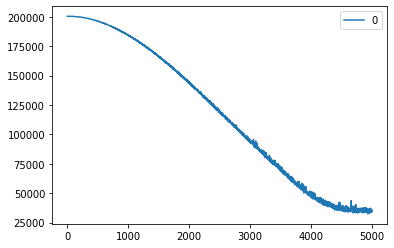

In [34]:
loss_plot = pd.DataFrame(loss_df).plot()

In [48]:
new_values = df.iloc[1,:8]

In [53]:
y_pred=""
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 42565.91796875


In [55]:
data=pd.DataFrame(y_test.tolist(),columns=["Actual"])
data['Predicted']=pd.DataFrame(y_pred.tolist())

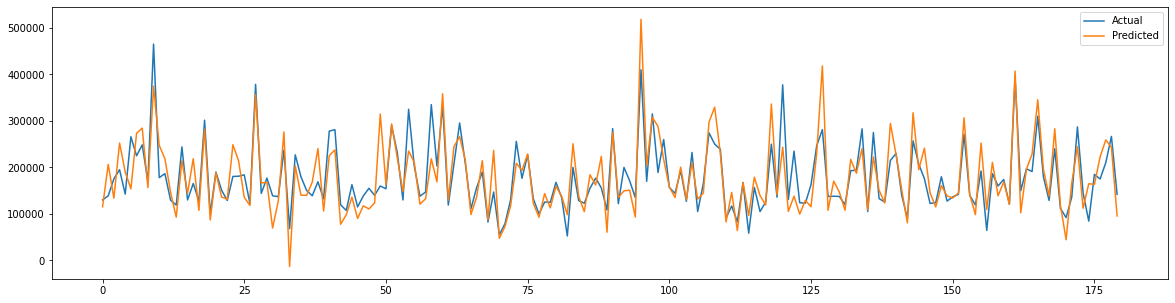

In [61]:

data.plot(figsize=(20,5))

In [63]:
torch.save(model,'PredictPrice.pt')